In [287]:
import sys
sys.path.append('src/')
import numpy as np
import torch, torch.nn
from library_function import library_1D
from neural_net import LinNetwork
from DeepMod import *
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
import torch.nn as nn
from torch.autograd import grad
from scipy.io import loadmat
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparing data

In [288]:
rawdata = loadmat('data/kinetics_new.mat')
raw = np.real(rawdata['Expression1'])
raw= raw.reshape((1901,3))
t = raw[:-1,0].reshape(-1,1)
X1= raw[:-1,1]
X2 = raw[:-1,2]

In [289]:
X = np.float32(t.reshape(-1,1))
y= np.vstack((X1,X2))
y = np.transpose(y)

In [290]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [291]:
y_train.shape

torch.Size([1000, 2])

# Building network

In [293]:
optim_config ={'lambda':1e-6,'max_iteration':5000}
lib_config={'poly_order':1, 'diff_order':2, 'total_terms':4}
network_config={'input_dim':1, 'hidden_dim':20, 'layers':8, 'output_dim':2}

# MSE Run

In [294]:
prediction, network = DeepMod_mse(X_train, y_train,network_config, optim_config)

Epoch | Total loss | MSE 
0 1.3E+00 1.3E+00
1000 8.6E-06 8.6E-06
2000 3.7E-06 3.7E-06
3000 1.1E-06 1.1E-06
4000 3.9E-06 3.9E-06


# Least square fit 

In [254]:
def func(X, a, b, c, d):
    x1,x2 = X
    return a + b*x1 + c*x2 + d*x1*x2

In [255]:
x1 = y[:,0]
x2 = y[:,1]
z1 = np.gradient(y[:,0],np.squeeze(X))
z2 = np.gradient(y[:,1],np.squeeze(X))

In [260]:
# initial guesses for a,b,c:
p0 = 0., 0., 0., 0.0
w1 = curve_fit(func, (x1,x2), z1, p0)[0]
w2 = curve_fit(func, (x1,x2), z2, p0)[0]

In [282]:
np.transpose(np.array((w1,w2)))

array([[ 1.61212549e-04,  1.99862519e-01],
       [-2.50109150e-01,  9.29521701e-05],
       [ 9.99827395e-01, -9.99854348e-01],
       [ 1.10820518e-04, -9.30906112e-05]])

In [283]:
init_coeff=torch.tensor(np.transpose(np.array((w1,w2))), dtype=torch.float32, requires_grad=True)

In [285]:
init_coeff

tensor([[ 1.6121e-04,  1.9986e-01],
        [-2.5011e-01,  9.2952e-05],
        [ 9.9983e-01, -9.9985e-01],
        [ 1.1082e-04, -9.3091e-05]], requires_grad=True)

In [286]:
y_t,theta, weight_vector = DeepMod_pretrained_nomse(X_train, y_train, network_config, lib_config, optim_config,network,init_coeff)

Epoch | Total loss | MSE | PI | L1 
0 1.7E+00 7.6E-01 9.7E-01 3.1E-07
[[-0.    0.2 ]
 [-0.25  0.  ]
 [ 1.   -1.  ]
 [-0.    0.  ]]


KeyboardInterrupt: 

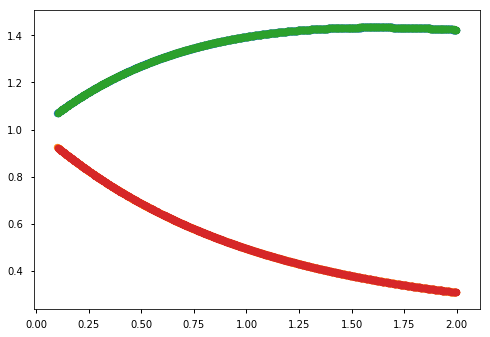

In [125]:
plt.scatter(X[:,0],y[:,0])
    plt.scatter(X[:,0],y[:,1])
    plt.scatter(X_train.detach().numpy(),prediction.detach().numpy()[:,0])
plt.scatter(X_train.detach().numpy(),prediction.detach().numpy()[:,1])
plt.show()

In [211]:
from scipy.optimize import curve_fit

In [207]:
def func(X, a, b, c, d):
    x1,x2 = X
    return a + b*x1 + c*x2 + d*x1*x2

In [234]:
x1 = y[:,0]
x2 = y[:,1]
z1 = np.gradient(y[:,0],np.squeeze(X))
z2 = np.gradient(y[:,1],np.squeeze(X))

In [235]:
# initial guesses for a,b,c:
p0 = 0., 0., 0., 0.0
curve_fit(func, (x1,x2), z1, p0)[0]

array([ 1.61212549e-04, -2.50109150e-01,  9.99827395e-01,  1.10820518e-04])

In [108]:
sparse_weight_vector, sparsity_pattern, prediction, network = DeepMod(X_train, y_train,network_config, lib_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 2.4E+00 9.0E-01 1.5E+00 1.0E-06
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


KeyboardInterrupt: 

In [202]:
testlib = np.array([y[:,0],y[:,1],y[:,0]*y[:,1]])

In [187]:
X.shape

(1900, 1)

In [188]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [205]:
print(reg_m(np.gradient(y[:,0]), x).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.376e+11
Date:                Sun, 09 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:00:25   Log-Likelihood:                 32269.
No. Observations:                1900   AIC:                        -6.453e+04
Df Residuals:                    1896   BIC:                        -6.451e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           1.11e-07   3.02e-08      3.672      0.0

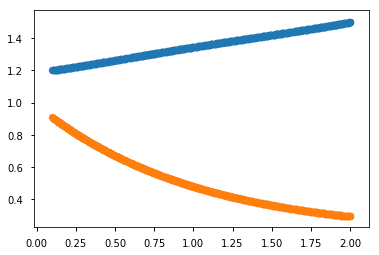

In [78]:
plt.scatter(X_train.detach().numpy(),prediction.detach().numpy()[:,0])
plt.scatter(X_train.detach().numpy(),prediction.detach().numpy()[:,1])

In [ ]:
prediction = network(torch.tensor(X, dtype=torch.float32))

In [15]:
prediction = prediction.detach().numpy()

In [64]:
x, y = np.meshgrid(X[:,0], X[:,1])

In [145]:
mask = torch.tensor((0,1,3))

In [157]:
mask

tensor([0, 1, 3])

In [158]:
sparse_coefs = torch.tensor((0.1,0.2,0.4)).reshape(-1,1)

In [159]:
sparse_coefs

tensor([[0.1000],
        [0.2000],
        [0.4000]])

In [291]:
dummy = torch.ones((5,3,1))
dummy2 = torch.ones((5,1,4))

In [292]:
(dummy @ dummy2).shape

torch.Size([5, 3, 4])

In [293]:
dummy.shape

torch.Size([5, 3, 1])

In [294]:
dummy.reshape(-1,3,1).shape

torch.Size([5, 3, 1])

In [164]:
dummy = dummy.reshape(2,2)

In [128]:
torch.where(coefs(mask),coefs,dummy)

TypeError: 'Tensor' object is not callable

In [45]:
x = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, x)
Z = np.sin(X)*np.sin(Y)


In [30]:
b = torch.ones((10, 2), dtype=torch.float32, requires_grad=True)

In [31]:
a = torch.tensor(np.ones((2,10)), dtype=torch.float32)

In [13]:
test=torch.tensor([[0.3073, 0.4409],
        [0.0212, 0.6602]])

In [17]:
torch.where(test>torch.tensor(0.3),test, torch.zeros_like(test))

tensor([[0.3073, 0.4409],
        [0.0000, 0.6602]])

In [83]:
test2[0,:].reshape(-1,1)

tensor([[0.3073],
        [0.4409],
        [0.0212],
        [0.6602]])

In [47]:
mask=torch.nonzero(test2[0,:])

In [39]:
mask=torch.reshape(torch.nonzero(test2), (1,4))

RuntimeError: shape '[1, 4]' is invalid for input of size 8

In [48]:
mask

tensor([[0],
        [1],
        [2],
        [3]])

In [54]:
test2[mask[1]]

RuntimeError: index 1 is out of bounds for dim with size 1

In [49]:
a.shape[1]

10